# CryptoCurrency Data Analysis

By: Muhammad Soban Amir

### Description 

This project fetches a csv file about historal data about three cryptocurries(BTC, ETH and XRP) from Yahoo Finance API. Then, cleans the data and typecasts into appropriate data types. It also handles the missing values if present using either interpolation or mean strategy. 

After that, it transforms the historical prices into log returns and calculates the mean, median, standard deviation, and the max log return. It also display the log returns in form of a correlation matrix.

Then, you can also see the original historical prices of each crypto in form of line chart.

There's also a bar chart to compare the mean of log returns.

There's also a graph visually showing when to buy and sell.

You can also print the raw unproccessed data if you like.

Finally, you can also store the data into a csv file for later use.

# Main Code

In [27]:
import requests
import pandas as pd
import numpy as np
import csv
import datetime
import matplotlib.pyplot as plt
import os
from bs4 import BeautifulSoup as bs

#Making a CryptoData class to perform different functions on the data of the historical prices
class CryptoData:
    #constructor
    def __init__(self, symbol):
        #symbol for currencies
        self.symbol = symbol
        #list to store data
        self.data = []
    
    #Fetches Historical Prices Data for three cryptocurrencies BTC, ETH, XRP from Yahoo Finance API
    def scrapeData_API(self, symbol, startTime, endTime):
        URL = f"https://query1.finance.yahoo.com/v7/finance/download/{symbol}?period1={startTime}&period2={endTime}&interval=1d&events=history&includeAdjustedClose=true"
        headers = { 'User-Agent': 'Mozilla/5.0' }
        r = requests.get(url=URL, headers=headers)
        #opening the file in binary format for writing data
        open(f'{symbol}.csv', 'wb').write(r.content)
    

    #Structuring data into a csv file
    def loadDataFromCsv(self, fileName):
        #opening the file for reading
        with open(fileName, 'r') as csvFile:
            #storing data row by row in readFile
            readFile = csv.DictReader(csvFile)
            #loop to read data row by row
            for i in readFile:
                #appedning every row in data list
                self.data.append(i)
                
    #Cleaning data in the csv file               
    def cleanData(self):
        for row in self.data:
            #strptime() is being used to parse the Date string
            # %Y stores the year in the format (XXXX) of four digits e.g. (2023)
            # %m stores the month in the format (XX) of two digits i.e. (01-12)
            # %d stores the date in the format (XX) of two digits i.e. (01-31)
            row['Date'] = datetime.datetime.strptime(row['Date'], "%Y-%m-%d").date()
            #converting datatype from string to float 
            row['Open'] = float(row['Open'])
            row['High'] = float(row['High'])
            row['Low'] = float(row['Low'])
            row['Close'] = float(row['Close'])
            row['Adj Close'] = float(row['Adj Close'])
            row['Volume'] = float(row['Volume'])
    
    #Handling Missing values in the data using the strategies 'Interpolation' and 'mean'
    def handleMissingValues(self, strategy='interpolation'):
        #converting the data list into a data frame
        df = pd.DataFrame(self.data)
        #converting the date format to our specified format e.g. Dec 03, 2023 to 2023-12-03
        df['Date'] = pd.to_datetime(df['Date'])
        #setting the index to date. Through this we can use the date as the index number
        df.set_index('Date', inplace=True)
        #The missing value will be replaced with interpolate() that will be in regard to the neighbouring values
        if strategy == 'interpolation':
            df.interpolate(inplace=True)
        #The missing value will be replaced with the mean
        elif strategy == 'mean':
            df.fillna(df.mean(), inplace=True)
        #exception will arrise if the user enters the wrong strategy
        else:
            raise ValueError(f"Invalid strategy: {strategy}. Supported strategies are 'interpolation' and 'mean'.")
        #converting a data frame to a list of dictionaries
        self.data = df.to_dict('DFtoDICT')
    
    #STEP 04
    #Using NUMPY to transform the data price into logarithmic returns
    def calculateLogReturns(self):
        #making a list to store all the prices present in the close column
        closePrices = [i['Close'] for i in self.data]
        logReturns = np.diff(np.log(closePrices))
        #starting with 1 because at index 0 there is no previous value to calculate the return for
        for i, row in enumerate(self.data[1:], start=1):
            #storing the logarithmic return on the index i-1 of logReturns list because i starts with 1
            row['Log Return'] = logReturns[i-1]
    
    #function to print the historical prices data in the list
    def printData(self):
        df = pd.DataFrame(self.data)
        #printing just the first 5 rows of the data frame
        print(df.head())
            
    #performing analysis on transformed data 
    def analysis(self):
        dfData = pd.DataFrame(self.data)
        #calculating mean of the logarithmic returns
        logReturnMean = dfData['Log Return'].mean(axis=0)
        print(f"Mean: {logReturnMean}")
        #calculating mean of the logarithmic returns
        logReturnMedian = dfData['Log Return'].median(axis=0)
        print(f"Median: {logReturnMedian}")
        #calculating median of the logarithmic returns
        logReturnSD = dfData['Log Return'].std(axis=0)
        print(f"Standard deviation: {logReturnSD}")
        #identifying the date with the maximum logarithmic returns
        #argmax() will return the index of the max date
        logReturnMaxRow = dfData.loc[dfData['Log Return'].argmax()]
        print(f"\nDate of Maximum returns: {logReturnMaxRow['Date']}")
        
    def saveToCsv(self):
        dfData = pd.DataFrame(self.data)
        dfData.to_csv(f'{self.symbol}-Transformed-Data.csv', index=False)

        
#correlation matrix between the returns of Bitcoin, Ethereum, and Ripple
def displayCorrelationMatrix(cryptocurrencies):
    dfData = pd.DataFrame()
    for i in cryptocurrencies:
        LogReturns = [row['Log Return'] for row in i.data if 'Log Return' in row]
        dfData[i.symbol] = pd.Series(LogReturns)
    #calculation correlation matrix of a data frame
    corrMatrix = dfData.corr()
    #displaying the correlation matrix
    plt.matshow(corrMatrix)
    plt.xticks(range(len(corrMatrix.columns)), corrMatrix.columns)
    plt.yticks(range(len(corrMatrix.columns)), corrMatrix.columns)
    plt.colorbar()
    plt.show()
        
#Making Line Chart for the Historical Data
def visualizeHistoricalData(cryptocurrencies):  
    for i in cryptocurrencies:
        dfData = pd.DataFrame(i.data)
        #plotting line chart 
        dfData.plot(x='Date', y=['Open', 'High', 'Low', 'Close'], kind='line', figsize=(10, 6))
        #setting title
        plt.title(f'Historical Data of {i.symbol}')
        #display
        plt.show()
    
#Making Bar Chart for the Mean Returns
def visualizeMeanReturns(cryptocurrencies):
    #list to store the mean returns of the cryptocurrency
    meanReturns = []
    for i in cryptocurrencies:
        #data frame for ecah row
        dfData = pd.DataFrame(i.data)
        #calculating mean
        meanReturn = dfData['Log Return'].mean()
        meanReturns.append(meanReturn)
    #Stting canvas size
    plt.figure(figsize = (6, 4))
    #plotting bar chart
    plt.bar([i.symbol for i in cryptocurrencies], meanReturns)
    plt.xlabel('Cryptocurrency')
    plt.ylabel('Mean Returns')
    plt.title('Mean Returns of Cryptocurrenices: BTC, ETH, XRP')
    #display
    plt.show()
    
# Generate buy/sell signals using crossover strategies (e.g., golden cross, death cross)
def visualizeCrossoverSignals(crypto, short_window=50, long_window=200):
    df = pd.DataFrame(crypto.data)
    # Calculate short-term (fast) and long-term (slow) moving averages
    df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()

    # Initialize signals list to store buy/sell signals
    signals = []

    # Generate buy/sell signals based on crossover strategies
    for i in range(1, len(df)):
        if df.at[i - 1, 'Short_MA'] < df.at[i - 1, 'Long_MA'] and df.at[i, 'Short_MA'] > df.at[i, 'Long_MA']:
            signals.append('Buy')
        elif df.at[i - 1, 'Short_MA'] > df.at[i - 1, 'Long_MA'] and df.at[i, 'Short_MA'] < df.at[i, 'Long_MA']:
            signals.append('Sell')
        else:
            signals.append('Hold')

    # Add signals to the DataFrame
    df['Signal'] = ['Hold'] + signals  # Add 'Hold' for the first row

    # Calculate accuracy of buy/sell signals
    correct_signals = sum(df['Signal'] != 'Hold')
    total_signals = len(df) - 1  # Excluding the first row due to NaN values in moving averages
    accuracy = correct_signals / total_signals

    # Print accuracy of signals
    print(f"Accuracy of signals: {accuracy * 100:.2f}%")

    # Plotting buy/sell signals
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], label='Close Price')
    plt.scatter(df[df['Signal'] == 'Buy']['Date'], df[df['Signal'] == 'Buy']['Close'], marker='^', color='green', label='Buy Signal')
    plt.scatter(df[df['Signal'] == 'Sell']['Date'], df[df['Signal'] == 'Sell']['Close'], marker='v', color='red', label='Sell Signal')
    plt.plot(df['Date'], df['Short_MA'], label=f'{short_window}-Day SMA', linestyle='--')
    plt.plot(df['Date'], df['Long_MA'], label=f'{long_window}-Day SMA', linestyle='-.')
    plt.title(f'Buy/Sell Signals for {crypto.symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

        
        
#Main function        
startYear = input("Enter start year YYYY: ")
startMonth = input("Enter start month MM: ")
startDay = input("Enter start day DD: ")

startTime = int(datetime.datetime(int(startYear), int(startMonth), int(startDay)).timestamp())

endYear = input("Enter end year YYYY: ")
endMonth = input("Enter end month MM: ")
endDay = input("Enter end day DD: ")

endTime = int(datetime.datetime(int(endYear), int(endMonth), int(endDay)).timestamp())

#Scrapping Data of the Cryptocurrency BITCOIN  
bitcoin = CryptoData('BTC-USD')
bitcoin.scrapeData_API("BTC-USD", startTime, endTime)
print("\nBitcoin Data fetched successfully!")
bitcoin.loadDataFromCsv('BTC-USD.csv')
bitcoin.cleanData()
bitcoin.calculateLogReturns()

#Scrapping Data of the Cryptocurrency ETHEREUM
ethereum = CryptoData('ETH-USD')
ethereum.scrapeData_API("ETH-USD", startTime, endTime)
print("Ethereum Data fetched successfully!")
ethereum.loadDataFromCsv('ETH-USD.csv')
ethereum.cleanData()
ethereum.calculateLogReturns()

#Scrapping Data of the Cryptocurrency RIPPLE
ripple = CryptoData('XRP-USD')
ripple.scrapeData_API("XRP-USD", startTime, endTime)
print("Ripple Data fetched successfully!")
ripple.loadDataFromCsv('XRP-USD.csv')
ripple.cleanData()
ripple.calculateLogReturns()

Enter start year YYYY: 2021
Enter start month MM: 1
Enter start day DD: 1
Enter end year YYYY: 2023
Enter end month MM: 1
Enter end day DD: 1

Bitcoin Data fetched successfully!
Ethereum Data fetched successfully!
Ripple Data fetched successfully!


# Data Analysis

In [28]:
print("\n\n1. Bitcoin")
print("2. Ethereum")
print("3. Ripple")

choice = input("\nEnter your choice: ")
print("\n")

if choice == "1":
    bitcoin.analysis()
elif choice == "2":
    ethereum.analysis()
elif choice == "3":
    ripple.analysis()
else:
    print("Invalid choice")



1. Bitcoin
2. Ethereum
3. Ripple

Enter your choice: 1


Mean: -0.000779729743042988
Median: -0.0006313136186886226
Standard deviation: 0.03808836785458643

Date of Maximum returns: 2021-02-08


# Correlation Matrix

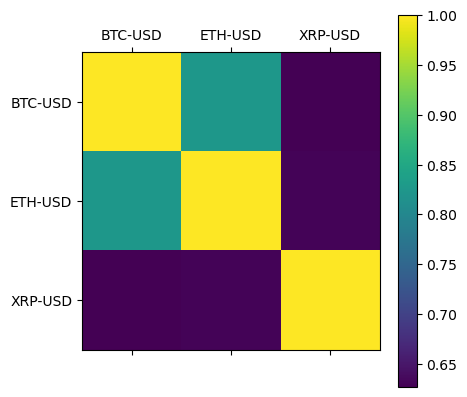

In [29]:
displayCorrelationMatrix([bitcoin, ethereum, ripple])

# Historical data line graph

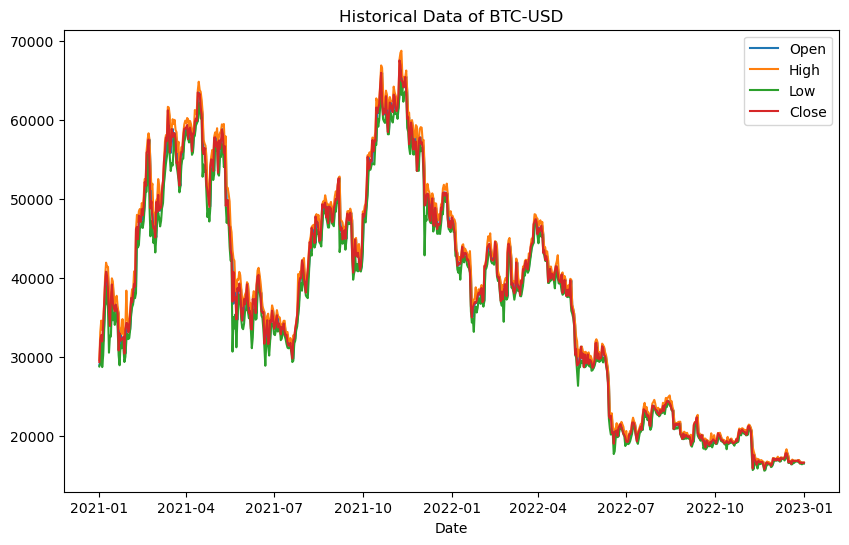

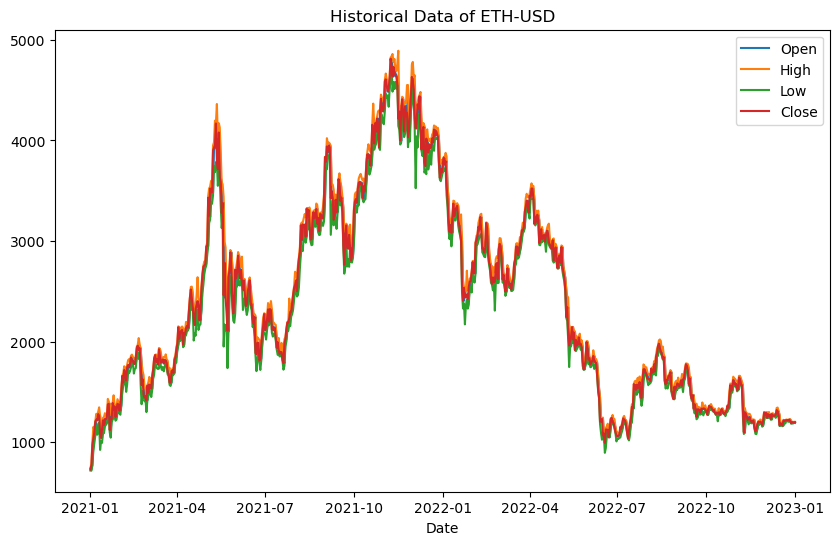

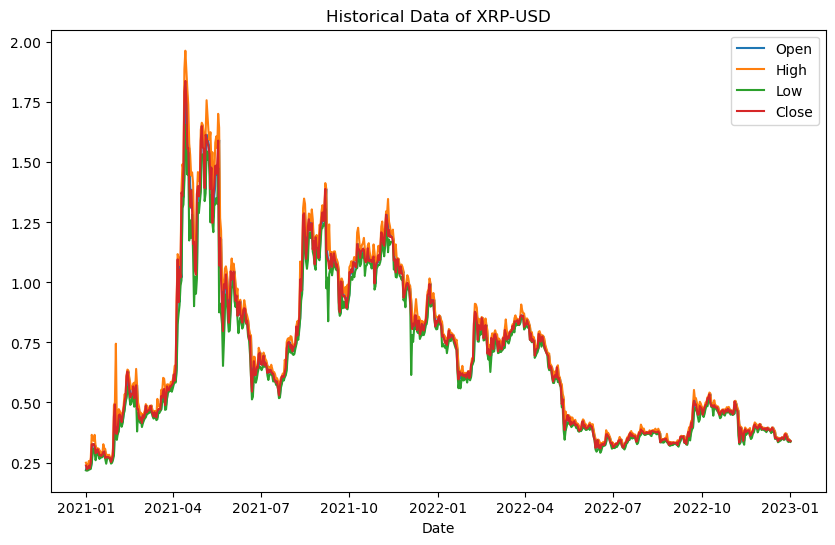

In [30]:
visualizeHistoricalData([bitcoin, ethereum, ripple])

# Mean returns bar graph

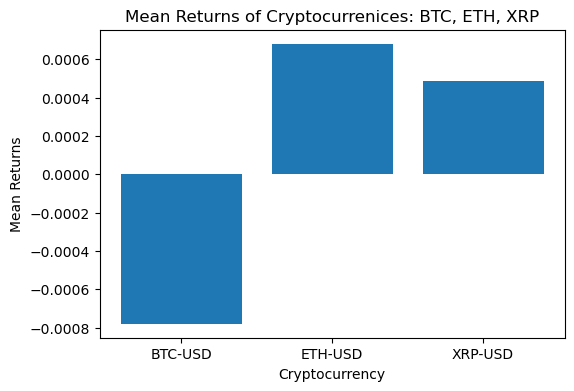

In [31]:
visualizeMeanReturns([bitcoin, ethereum, ripple])

# Buy/Sell Signals

The accuracy of the signals is not great, but it shows the idea how they generated.



1. Bitcoin
2. Ethereum
3. Ripple

Enter your choice: 2


Accuracy of signals: 0.41%


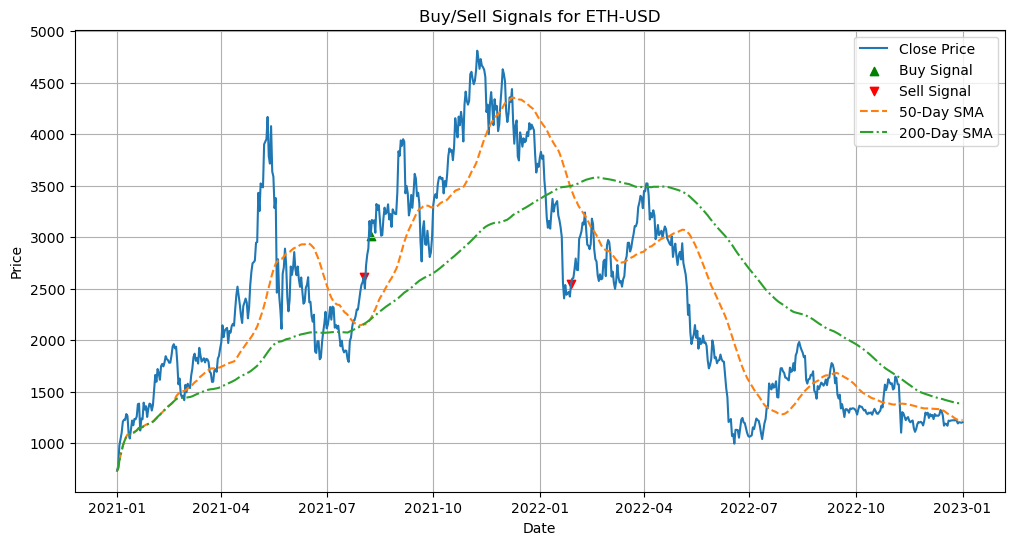

In [32]:
print("\n\n1. Bitcoin")
print("2. Ethereum")
print("3. Ripple")

choice = input("\nEnter your choice: ")
print("\n")

if choice == "1":
    visualizeCrossoverSignals(bitcoin)
elif choice == "2":
    visualizeCrossoverSignals(ethereum)
elif choice == "3":
    visualizeCrossoverSignals(ripple)
else:
    print("Invalid choice")


# Print data


In [24]:
print("\n\n1. Bitcoin")
print("2. Ethereum")
print("3. Ripple")

choice = input("\nEnter your choice: ")

if choice == "1":
    bitcoin.printData()
elif choice == "2":
    ethereum.printData()
elif choice == "3":
    ripple.printData()
else:
    print("\nInvalid choice")



1. Bitcoin
2. Ethereum
3. Ripple

Enter your choice: 1
         Date      Open      High       Low    Close*  Adj Close**  \
0  2024-03-23  63810.84  64308.29  63161.45  63998.63     63998.63   
1  2024-03-21  67911.59  68199.99  64580.92  65491.39     65491.39   
2  2024-03-20  61930.16  68115.26  60807.79  67913.67     67913.67   
3  2024-03-19  67556.13  68106.93  61536.18  61912.77     61912.77   
4  2024-03-18  68371.30  68897.13  66594.23  67548.59     67548.59   

         Volume  Log Return  
0  4.030092e+10         NaN  
1  4.448035e+10    0.023057  
2  6.679263e+10    0.036319  
3  7.421584e+10   -0.092511  
4  4.926158e+10    0.087121  


# Save to CSV


In [10]:
print("\n\n1. Bitcoin")
print("2. Ethereum")
print("3. Ripple")

choice = input("\nEnter your choice: ")

if choice == "1":
    bitcoin.saveToCsv()
    print("\nSaved to CSV file Successfully!")
elif choice == "2":
    ethereum.saveToCsv()
    print("\nSaved to CSV file Successfully!")
elif choice == "3":
    ripple.saveToCsv()
else:
    print("\nInvalid choice")
    print("\nSaved to CSV file Successfully!")



1. Bitcoin
2. Ethereum
3. Ripple

Enter your choice: 1

Saved to CSV file Successfully!
